In [1]:
using Pkg
Pkg.activate("..")
using Plots, PhasorNetworks, Random, DifferentialEquations

  Activating project at `~/code/PhasorNetworks.jl`


# Similarity

Continuing on from the previous notebooks, we'll now compute the similarity of an HD symbol to another HD symbol via two methods: one, a standard trig-based method, and the other, via the interference of waves! 

Let's pick back up where we were previously: computing the similarity of HD symbols (long vectors of phase values). Previously, we computed these values by taking the mean of the cosine distance between symbols:

In [2]:
prng_key = Xoshiro("ICONS2025")
n_phases = 1024

1024

In [3]:
symbol_a = random_symbols((n_phases, 1), prng_key)
symbol_b = random_symbols((n_phases, 1), prng_key);

And, as we saw, random symbols have a 99.9999....% (depending on the number of phase values) chance of being highly dissimilar:

In [4]:
similarity(symbol_a, symbol_b)

1-element Vector{Float32}:
 0.014428152

We began to explore the question of how you can manipulate symbols to make them more or less similar to one another in the previous notebook (01). Now, let's explore this a bit further.

As you determined in the previous notebook, to make a symbol which is *exactly* dissimilar to another, you can take the first and "rotate" each of its angles by $\pi / 2$ ($0.5$ normalized radians). This makes each angle exactly orthogonal to the other (or, at least as close to perfectly orthogonal we can get while using floating-point numbers).

In [5]:
symbol_a_not = symbol_a .+ 0.5;

In [6]:
similarity(symbol_a, symbol_a_not)

1-element Vector{Float64}:
 -4.371139000186249e-8

In fact, we can create a whole series of symbols with a varying degree of similarity to *a* by simply adding normalized angles between $0$ and $0.5$:

In [7]:
rotations = range(0.0, 0.5, length=21)
symbol_a_family = [symbol_a .+ angle for angle in rotations] |> stack
similarity_family = similarity(symbol_a, symbol_a_family);

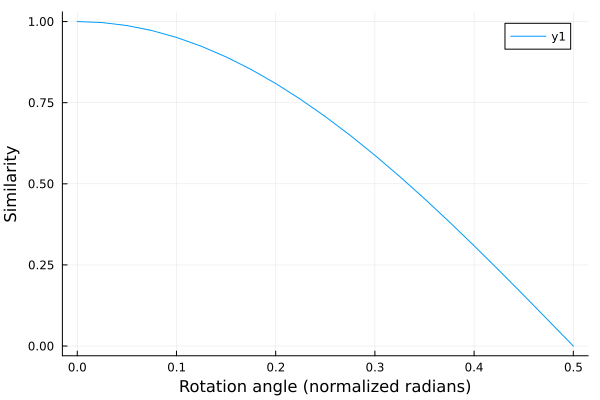

In [8]:
plot(rotations, similarity_family')
xlabel!("Rotation angle (normalized radians)")
ylabel!("Similarity")

Quick exercise: what happens if we go past an offset of 0.5? Does a pattern emerge? How far does it take for this pattern to repeat?

In [ ]:
rotations = range(0.0, ?, length=21)
symbol_a_family = [symbol_a .+ angle for angle in rotations] |> stack;

In [ ]:
plot(rotations, similarity(symbol_a, symbol_a_family)')
xlabel!("Rotation angle (normalized radians)")
ylabel!("Similarity")

Now that we've explored an experiment which allows us to calculate a variety of similarity ranges, rather than just 0, 1, or -1, we can explore how well we can replicate these calculations using a secondary method: the interference of waves (notebook 02). 

Rather than manually defining the differential equations this time, we'll take advantage of the code which already exists in PhasorNetworks.jl to carry out this experiment. Because we have limited time, we'll be skipping over some of the "behind the scenes" magic which is going on here and summarize it briefly as we apply it!

* SpikingArgs determines a lot of parameters (leakage, resonant frequency, solver arguments, etc) and stores them conveniently in a structure we can pass from function to function.

In [10]:
spk_args = SpikingArgs()

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


* Previously, we defined a current function which drove individual current inputs to resonate-and-fire neurons. Here, we'll use this function to automatically convert our symbols into spike trains. Each spike train contains a series of times and indices - these cause currents to arise in each neuron at an appropriate time, causing it to resonate with the correct phase value relative to its group!

In [11]:
input_spikes_a = phase_to_train(symbol_a[:,:,1:1], spk_args=spk_args, repeats=6)

Spike Train: (1024, 1, 1) with 6144 spikes.

In [12]:
input_spikes_a_family = phase_to_train(symbol_a_family, spk_args=spk_args, repeats=6)

Spike Train: (1024, 1, 21) with 129024 spikes.

* Now, we use a Julia feature - multiple dispatch - to call the same ``similarity`` function on a different type of inputs - ``SpikeTrain``s. Behind the scenes, this function will take these inputs, convert them to current impulses which drive a series of R&F neurons, solves the differential equations through time, combines the outputs, and computes the equivalent similarity values from the outputs of those interference patterns!

Note: you can look at how all of this is accomplished in the source at ``src/vsa.jl:195``

In [13]:
osc_similarity = similarity(input_spikes_a, input_spikes_a_family, tspan=(0.0, 6.0), spk_args=spk_args);
size(osc_similarity)

(1, 21, 602)

As you can see, we end up with a 1 x 21 x 602 matrix. This is because we now have similarity values calculated at multiple points in time - each point of the wave we've simulated!

Let's look at how the similarity values evolve over time:

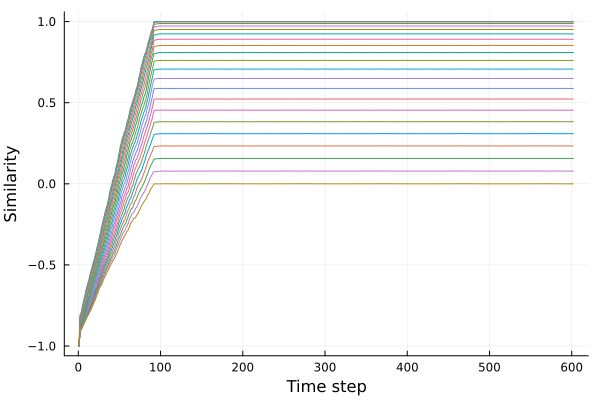

In [14]:
plot(osc_similarity[1,:,:]', legend=false)
xlabel!("Time step")
ylabel!("Similarity")

As the oscillators integrate the input spikes, resonate with them, and reach a steady-state phase, the interference of their outputs converges to levels which are transformed into the similarity values we observe here! How closely do they match those we calculated with the "atemporal" trig versions? Pretty closely!

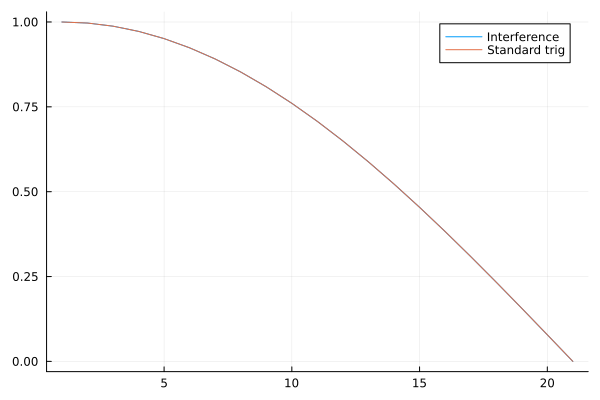

In [15]:
plot(osc_similarity[1,:,end], label="Interference")
plot!(similarity_family', label="Standard trig")

We actually can't see the two lines because they overlap too closely. Instead, let's compare the differences between the two:

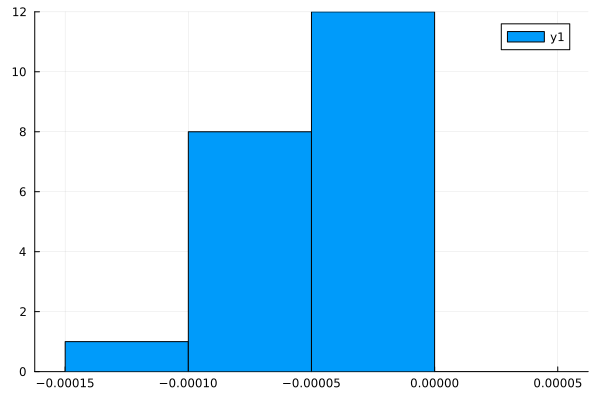

In [16]:
histogram(vec(osc_similarity[1,:,end] .- similarity_family[1,:]))

As we can see, these values are very close, with less than 1% errror! There's a large variety of different  parameters we can change to affect this performance, however. Try exploring some parameters - affecting the solver, the R&F neuron, and the symbols themselves - and see which ones have the greatest effect on the amount of error between the two calculation methods.

In [17]:
function compare_similarity_error(;leakage::Real = -0.2,
                                period::Real = 1.0,
                                shift_range::Real = 0.5,
                                solver_dt::Real = 0.01,
                                tspan::Tuple = (0.0, 6.0),
                                n_phases::Int = 1024,
                                seed = "ICONS2025",)
    prng_key = Xoshiro(seed)
    spk_args = SpikingArgs(leakage = leakage,
                            t_period = period,
                            solver_args = Dict(:adaptive => false,
                                        :dt => solver_dt,
                                        :save_start => true,))

    symbol_a = random_symbols((n_phases, 1), prng_key)
    rotations = range(0.0, shift_range, length=21)
    symbol_a_family = [symbol_a .+ angle for angle in rotations] |> stack
    similarity_family = similarity(symbol_a, symbol_a_family)

    repeats = ceil(Int, tspan[2])
    input_spikes_a = phase_to_train(symbol_a[:,:,1:1], spk_args=spk_args, repeats=repeats)
    input_spikes_a_family = phase_to_train(symbol_a_family, spk_args=spk_args, repeats=repeats)
    osc_similarity = similarity(input_spikes_a, input_spikes_a_family, tspan=tspan, spk_args=spk_args)

    error = vec(osc_similarity[1,:,end] .- similarity_family[1,:])
    return error
end


compare_similarity_error (generic function with 1 method)

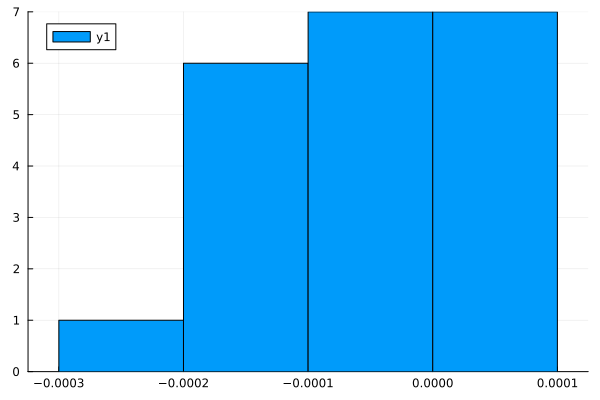

In [18]:
compare_similarity_error(n_phases=256) |> histogram

In [ ]:
compare_similarity_error(?) |> histogram

We've introduced a few new concepts in this notebook to carry out our experiment. Let's summarize them:
* We can control how similar a vector is to itself by rotating the angles contained in it.
* We can carry out the similarity calculation by superimposing waves instead of directly computing trig identities.

We can expand on these concepts further to build a fully-functional HD computing system which can operate entirely by superimposing waves and rotating angles! 

* Instead of superimposing just two waves to calculate similarity, we can superimpose *many* waves to produce an *average* phase of all of them! This superposition of many waves implements the *bundling* operator in HD computing, in which several symbols are combined into one which is (somewhat) similar to all inputs.

* Instead of just rotating a symbol with its own phase values, we can rotate it with the angles from another symbol! This allows the information from *both* to be combined into a single output which is similar to neither inputs. 

With both of these operations implemented via waves, we can implement any variety of algorithms which can be fully executed via oscillatory components.

In the next notebook, we'll (quickly) go over how this can be used to create a full neural network.
